In [3]:
import pickle  # data loading
import gzip  # data loading
from scipy.stats.stats import pearsonr  # correlation

import numpy as np  # linear algebra
import matplotlib.pyplot as plt  # plotting

# output format
np.set_printoptions(precision=2)
np.seterr(all='raise') # elevate all warnings to errors

def load_mnist_data():
    """Loads the data, returns training_data, validation_data, test_data."""
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        return pickle.load(f, encoding='latin1')
    
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_mnist_data()

We have 50000 training images, 10000 validation images and 10000 test images, let's reshape them to 2-dimensional data:

In [4]:
x_train = x_train.reshape((50000, 28, 28))
x_val   = x_val.reshape((10000, 28, 28))
x_test  = x_test.reshape((10000, 28, 28))

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


The pixel values are between 0 and 1:

In [5]:
x_train.min(), x_train.max()

(0.0, 0.99609375)

## Random sampling of digits

The following function creates a set of random sample pixels

In [6]:
def create_sample(n):
     return np.random.randint(28, size=(n, 2))

def create_samples(neuron_count, sample_size):
     return np.random.randint(28, size=(neuron_count, sample_size, 2))
    

The activation function sums over the sample pixels in an image

In [7]:
def activation(x, sample):
    return np.sum(x[sample[:,0],sample[:,1]])

Plotting some images and demonstrate activation function:

Activation on 5 is 7.7890625
Activation on 0 is 6.9765625
Activation on 4 is 5.4179688
Activation on 1 is 3.6992188
Activation on 9 is 8.3359375
Activation on 2 is 8.984375
Activation on 1 is 4.2070312
Activation on 3 is 8.890625
Activation on 1 is 4.15625
Activation on 4 is 6.0195312


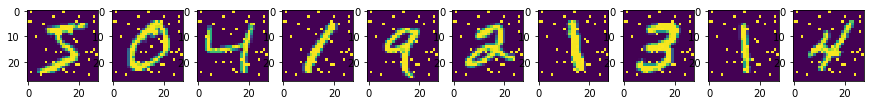

In [8]:
# some sampling points
sample = create_sample(40)

# plot first ten digits
plt.figure(figsize=(15,10))
for i in range(10):
    # highlight sample points in image
    digit = x_train[i]
    digit_with_highlight = digit.copy()
    digit_with_highlight[sample[:,0], sample[:,1]] = 1.0

    # plot digit
    plt.subplot(1,10,i+1)
    plt.imshow(digit_with_highlight)
    
    print("Activation on", str(y_train[i]), "is", activation(digit, sample))

We can see that if we look at the sum over sample pixels, they respond higher on some digits and lower on others. But how stable are these biases?

## Activation values per digit for one specific pixel sample set

To evaluate the different activation values of one specific pixel set, the activations for different digit classes were grouped together here.

In [9]:
activations_per_digit = [[], [], [], [], [], [], [], [], [], [],]
for i in range(x_train.shape[0]):
    activations_per_digit[y_train[i]].append(activation(x_train[i], sample))
    

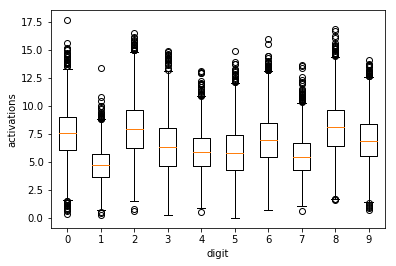

In [10]:
plt.boxplot(activations_per_digit, labels=list(range(10)))
plt.xlabel('digit')
plt.ylabel('activations')
None

## Correlations between activation vectors on 10 single digits



In [9]:
# manual implementation of pearsonr, just to be sure
def pcc(X, Y):
   
    X -= X.mean(0)
    Y -= Y.mean(0)
    
    # Standardise X and Y
    X /= X.std(0)
    Y /= Y.std(0)
 
    # Compute mean product
    return np.mean(X*Y)

v1 = np.random.normal(size=10)
v2 = np.random.normal(size=10)

# compare to reference implementation
print("comparing", v1, "\nand", v2)
print("scipy implementation", pearsonr(v1, v2)[0])
print("manual implementation", pcc(v1, v2))

comparing [ 0.05  0.45 -0.82  1.18  0.33  0.    0.32  0.08 -0.54 -0.2 ] 
and [ 0.45 -0.39 -0.38  0.36  1.49 -0.58 -1.16 -0.04  0.44  0.64]
scipy implementation 0.07048254439485485
manual implementation 0.0704825443948549


In [10]:
# prepare all the indicies for a specific digit class for lookup
indices_by_digit_class = []

for i in range(10):
    indices = np.argwhere(y_train == i)
    indices_by_digit_class.append(indices.reshape(-1))

In [11]:
def collect_correlations2(pixel_count, num_samples = 10000):
    correlations = []
    
    for i in range(num_samples):
        sample = create_sample(pixel_count)

        # create two random digit sets with digits 0, 1, 2, ..., 9
        activations1 = []
        activations2 = []

        for k in range(10):
            # find two random digits of class k
            index1 = np.random.choice(indices_by_digit_class[k])
            index2 = np.random.choice(indices_by_digit_class[k])

            #print(y_train[index1])
            #print(y_train[index2])

            # calculate the activation
            activations1.append(activation(x_train[index1], sample))
            activations2.append(activation(x_train[index2], sample))

        # calc pearson correlation
        try: 
            # c = pearsonr(activations1, activations2)[0]
            c = pcc(np.array(activations1), np.array(activations2))
            correlations.append(c)
        except:
            pass # skip values where one of the vectors is the zero vector
                        
            
    return correlations
        
pixel_counts = [10, 20, 40, 80]
correlations = list(map(collect_correlations2, pixel_counts))
    

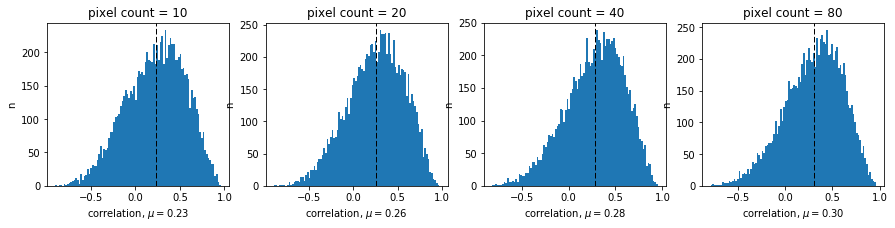

In [12]:
plt.figure(figsize=(15,3))

for i, pixel_count in enumerate(pixel_counts):
    ax = plt.subplot(1,4,i+1)
    ax.set_title("pixel count = "+str(pixel_count))
    ax.hist(correlations[i], bins=100)
    ax.set_xlabel('correlation, $\mu ='+'{:20,.2f}'.format(np.mean(correlations[i]))+'$')
    ax.set_ylabel('n')
    ax.axvline(np.mean(correlations[i]), color='k', linestyle='dashed', linewidth=1)

## Could a small sample of pixels be used to cluster and classify digits?

In the following test, these steps are performed:

* a sample of 40 pixels in the digit space (28, 28) is chosen (completely random, might even contain duplicates)
* for every of the 50000 digits, the 40 pixels are sampled, resulting in a vector wih 40 elements per digit sample. Everyone of these vectors can still be associated with the correct label
* these 50000 vectors are clustered into 10 clusters with kmeans
* for each of the cluster, the most common digit label in this cluster is chosen as the cluster representative (for example when a lot of vectors from 0-digits are in this cluster, this cluster now represents 0s)
* then the number of correctly classified digits is calculated (example: if a 0 dominates a cluster, all the zeros in that cluster are calculated as correct, all other digits as misclassified)

Finally, this kmeans implementation is used on the validation set (10000 digits). It yields accuracy rates of 30-40% (random would be 10%), which shows that a sample of 40 pixels can be used to create a weak classifier

Percentage of digits sitting in correct class (= approx. classification accuracy on validation set):
0.4111


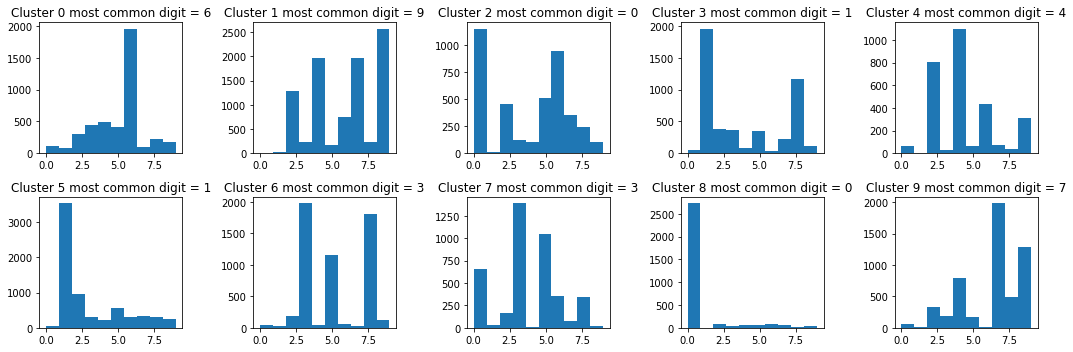

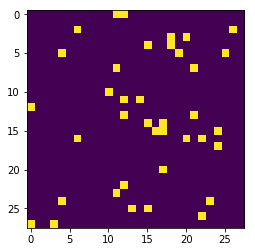

In [17]:
from sklearn.cluster import KMeans

sample_size = 40
sample = create_sample(sample_size)

# sample all digits, vecs will be 50000 x sample_size
vecs = np.zeros((50000, sample_size))

for i, digit in enumerate(x_train):
    vecs[i,:] = digit[sample[:,0],sample[:,1]]

# run clustering using KMeans
kmeans = KMeans(n_clusters=10).fit(vecs)

# will contain the most common digit per cluster
max_digits = np.zeros(10)

plt.figure(figsize=(15,5))

# loop over the 10 clusters identified by kmeans
for i in range(10):
    # find all positions of the vectors in the ith cluster
    positions_of_class = np.argwhere(kmeans.labels_ == i)[:,0]
    
    # lookup which digit these vectors correspond to
    digits_in_class = y_train[positions_of_class] 

    # determine most common digit in class
    max_digit = np.bincount(digits_in_class).argmax()
    max_digits[i] = max_digit
    
    # plot historgram of digits clustered in ith cluster
    ax = plt.subplot(2,5,i+1)
    ax.set_title("Cluster "+str(i)+" most common digit = "+str(max_digit))
    plt.hist(digits_in_class, bins=10)

plt.tight_layout()
    
# visualize how the sample points are distributed over the pixel space
sample_2D = np.zeros((28,28))
sample_2D[sample[:,0],sample[:,1]] = 1

plt.figure()
plt.imshow(sample_2D)

# create samples for validation set
# sample all digits, vecs will be 10000 x sample_size
validation_size = x_val.shape[0]
vecs_val = np.zeros((validation_size, sample_size))

for i, digit in enumerate(x_val):
    vecs_val[i,:] = digit[sample[:,0],sample[:,1]]
    
# in which cluster would these vectors be?
predicted_classes = kmeans.predict(vecs_val)

# translate cluster to predicted digit by reusing the most common digit array
predicted_digits = max_digits[predicted_classes]

print("Percentage of digits sitting in correct class (= approx. classification accuracy on validation set):")

# calculate accuracy
print(np.sum(y_val == predicted_digits)/validation_size)
